<a href="https://colab.research.google.com/github/TUIlmenauAMS/PsychoacousticLoss/blob/main/psyacLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Perceptually Motivated Audio Loss Functions for Deep Learning
## <center> Gerald Schuller
## <center> Ilmenau University of Technology
- Example:
  - Different type of Distortions: uniform quantization,
  - perceptually shaped quantization from MPEG AAC encoding and decoding

- For **usage** examples go to cell **"The psycho-acoustic loss function"**

## Goal: Preceptual loss function which mimics the perceptual quality impression of the human ear

- We want the minimum of our loss function appear where it sounds best for the human ear.
- This means: Lower loss function should mean better sounding audio

## Previous approaches
- Log Spectral Difference (least complex),
- Multi Scale Spectral Loss (more complex)...

## New approach:
- Psycho-Acoustic Loss Function (most complex)
- It uses a detailed psycho-acoustic model from audio coding
- It computes the average of spectral differences, normalized to the masking threshold of the original signal
- Arguably the most precise measure for similarity with human hearing preference


# Examples, Demos
- Start with downloading audio files and code from our Github repository "TUIlmenauAMS"
- Install needed modules

In [16]:
import sys
#%cd /content/
!git clone https://github.com/TUIlmenauAMS/Python-Audio-Coder
#%cd /content/Python-Audio-Coder
#sys.path.append('./Python-Audio-Coder')
currentpath=sys.path[0]
sys.path.append(currentpath+'/Python-Audio-Coder')
plotlyplot=False #Set it false for matplotlib for RISE presentation

fatal: destination path 'Python-Audio-Coder' already exists and is not an empty directory.


In [17]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

%matplotlib inline

## Load Test Audio File

<ipython-input-18-8db4d80be525>:2: WavFileWarning:

Chunk (non-data) not understood, skipping it.



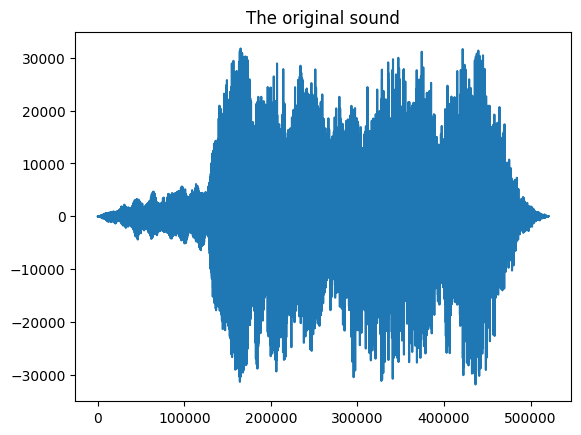

In [18]:
#Test audio file:
fs, snd =wav.read('./Python-Audio-Coder/fantasy-orchestra.wav')
plt.plot(snd[:,0])
plt.title("The original sound")
Audio('./Python-Audio-Coder/fantasy-orchestra.wav')

## Create different distorted versions
### Uniform quantization:

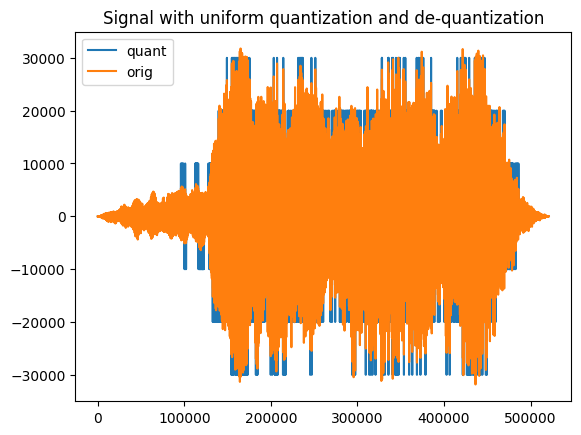

In [19]:
import plotly.express as px
import plotly.tools as tls
import pandas as pd

#Audio signal with uniform quantization and de-quantization
snd_quant=(np.round(snd/10000))*10000
wav.write('fantasy-orchestra_quant.wav', rate= fs, data=snd_quant.astype(np.int16))

if plotlyplot:
  d = {'orig': snd[:,0], 'quant': snd_quant[:,0]}
  df = pd.DataFrame(data=d)
  fig=px.line(df,title="Originial and signal with uniform quantization and de-quantization")
  fig.show()
else:
  plt.plot(snd_quant[:,0])
  plt.plot(snd[:,0])
  plt.legend(('quant','orig'))
  plt.title("Signal with uniform quantization and de-quantization")

Audio('fantasy-orchestra_quant.wav')

### Psycho-acoustic quantization from AAC encoding and decoding:

The AAC encoding/decoding introduces a delay that needs to be compensated:

In [20]:
#Psycho-acoustic quantization from AAC coding and decoding:
!apt install ffmpeg 1> /dev/null
!ffmpeg -y -i ./Python-Audio-Coder/fantasy-orchestra.wav -b:a 64k fantasy-orchestra64k.aac
!ffmpeg -y -i fantasy-orchestra64k.aac fantasy-orchestradec_aac.wav
print("Observe file size for compression ratio:")
!ls -l fantasy-orchestra64k.aac fantasy-orchestradec_aac.wav
#Listen:
Audio('fantasy-orchestradec_aac.wav')



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --en

minlength= 520972


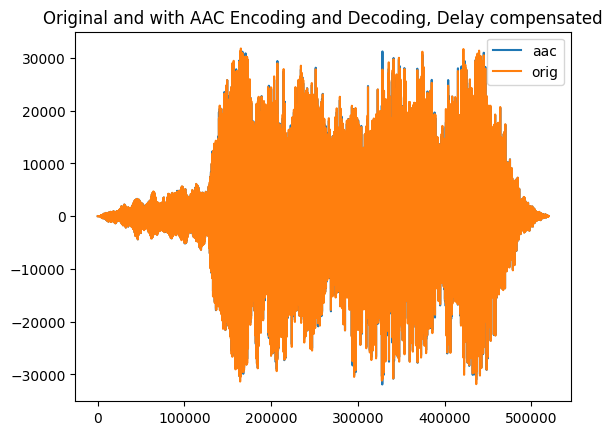

In [21]:
#Plot:
import plotly.express as px
import plotly.tools as tls
import pandas as pd

fs, snd_aac =wav.read('fantasy-orchestradec_aac.wav')

minlength=min(snd.shape[0],snd_aac.shape[0])
print("minlength=", minlength)
delay=120 #aac delay in samples
delay=1024

if plotlyplot:
  d = {'orig': snd[:minlength-delay,0], 'aac': snd_aac[delay:minlength,0]}
  df = pd.DataFrame(data=d)
  fig=px.line(df, title="Original and with AAC Encoding and Decoding, Delay compensated")
  fig.show()
else:
  plt.plot(snd_aac[delay:minlength,0])
  plt.plot(snd[:minlength-delay,0])
  plt.legend(('aac','orig'))
  plt.title("Original and with AAC Encoding and Decoding, Delay compensated")

snd=snd.astype(float)
snd_aac=snd_aac.astype(float)

#plt.plot((snd[:minlength-delay,0]-snd_aac[delay:minlength,0])**2)
#plt.show()

#write delay compensated signal to file, for quality measure:
wav.write('fantasy-orchestradec_aac_delcomp.wav', fs, snd_aac[delay:minlength,:].astype(np.int16))

## Mean Squared Error (MSE) of Quantized and AAC encoded/decoded Version

In [22]:
#import torch.nn
from sklearn.metrics import mean_squared_error

#MSE needs float type to avoid overflow:
snd=snd.astype(float)
snd_quant=snd_quant.astype(float)

#mean squared error:
#loss_mse = torch.nn.MSELoss()
#loss_mse(snd,snd_quant)
mse_quant=mean_squared_error(snd,snd_quant)

#print("mean squared error of uniform quantization:", np.mean((snd-snd_quant)**2))
#print("Torch MSELoss:", loss_mse(snd,snd_quant))
print("Sklearn mean_squared_error of uniform quantization:", mse_quant)

mse_aac=mean_squared_error(snd[:minlength-delay,:],snd_aac[delay:minlength,:])
#print("mean squared error of mpeg quantization:", np.mean((snd[:minlength-delay,:]-snd_aac[delay:minlength,:])**2))
print("Sklearn mean squared error of mpeg quantization:",mse_aac)

print("ratio mse_aac/mse_quant=",mse_aac/mse_quant)

Sklearn mean_squared_error of uniform quantization: 6310072.625274487
Sklearn mean squared error of mpeg quantization: 183575.491806873
ratio mse_aac/mse_quant= 0.029092453083911615


Observe:
- the **MSE for the AAC encoded/decoded** version is much worse, about **5 times higher**, than for the **uniform quantized** version,
- even though the **AAC encoded/decoded** signal **sounds "orders of magnitude" better**!

## Previous approaches for perceptually motivated loss functions


### Log spectral difference (not so complex)

* A distance measure (in dB) between log magnitudes of the spectra.
* Much less computational expensive.
* Can work well in certain applications.

Reference:<br>
Rabiner, L. and Juang, B., 1993. Fundamentals of speech recognition. Englewood Cliffs, N.J.: PTR Prentice Hall.

In [23]:
# Imports
#%cd /content/
!git clone https://github.com/TUIlmenauAMS/PsychoacousticLoss
#%cd /content/PsychoacousticLoss
#sys.path.append('./PsychoacousticLoss')
currentpath=sys.path[0]
sys.path.append(currentpath+'/PsychoacousticLoss')
import torch #LSDLoss is defined for torch type
from lsd_loss import LSDLoss #lsd_loss defined in Python file
loss_lsd = LSDLoss()
lsd_aac_original = loss_lsd(torch.from_numpy(snd_aac[delay:minlength,0]),torch.from_numpy(snd[:minlength-delay,0]))
print('LSD Loss aac:', lsd_aac_original)
lsd_quant_original = loss_lsd(torch.from_numpy(snd_quant[:,0]), torch.from_numpy(snd[:,0]))
print('LSD Loss Quanitzed:', lsd_quant_original)

fatal: destination path 'PsychoacousticLoss' already exists and is not an empty directory.
LSD Loss aac: tensor(0.4224, dtype=torch.float64)
LSD Loss Quanitzed: tensor(6.8404, dtype=torch.float64)


Observe:
* The LSD loss of the quantized audio is now about **7 times higher** than for the AAC quantized version, reflecting the preference of the human ear.

### Multi Scale Spectral Loss

* More computational expensive than the LSD but less than the psycho-acoustic loss.
* Given two audio files, we compute their (magnitude) spectrogram $S_i$ and $\hat{S_i}$, respectively, with a given FFT size $i$, and define the loss as the sum of the L1 difference between $S_i$ and $\hat{S_i}$ as well as the L1 difference between log Si and log $\hat{S_i}$. The total reconstruction loss is then the sum of all the spectral losses with different FFT sizes.

Reference:<br>
Jesse Engel, Lamtharn (Hanoi) Hantrakul, Chenjie Gu, & Adam Roberts (2020). DDSP: Differentiable Digital Signal Processing. In International Conference on Learning Representations.

In [24]:
!pip install asteroid 1> /dev/null
from asteroid.losses import SingleSrcMultiScaleSpectral
import torchaudio

loss_multiScaleSpectral = SingleSrcMultiScaleSpectral()
snd_torch, sr = torchaudio.load('./Python-Audio-Coder/fantasy-orchestra.wav')
snd_quant_torch, sr = torchaudio.load('fantasy-orchestra_quant.wav')
snd_aac_torch, sr = torchaudio.load('fantasy-orchestradec_aac_delcomp.wav')
print(snd_aac_torch.shape)
minlength=min(snd_aac_torch.shape[1], snd_torch.shape[1])
print('minlength=',minlength)
multiScale_aac_original = loss_multiScaleSpectral(snd_aac_torch[:,:minlength],snd_torch[:,:minlength])
print('\nMulti Scale Spectral Loss aac:', multiScale_aac_original.numpy()/1000000)
multiScale_quant_original = loss_multiScaleSpectral(snd_quant_torch,snd_torch)
print('Multi Scale Spectral Loss Quanitzed:', multiScale_quant_original.numpy()/1000000)

torch.Size([2, 519948])
minlength= 519948

Multi Scale Spectral Loss aac: [1.70419838 1.73306012]
Multi Scale Spectral Loss Quanitzed: [9.893535 9.696801]


Observe:
- These are the loss function for the 2 audio channels.
- The loss value for the uniformly quantized version if about **4 times higher** than for the AAC quantized version.

# New Approach: The Psycho-Acoustic Loss Function
* Using a psycho-acoustic model from audio coding
* average of spectral differences, normalized to the masking threshold of the original signal
* Arguably the most precise measure for similarity with human hearing preference

##Example for a tone as audio signal
<center>
    <br>
    <img src='https://raw.githubusercontent.com/TUIlmenauAMS/AudioCoding_Tutorials/main/images/ac_05_01_ltq.png?raw=1' width='600'>
</center>  

## Display the computed psyco-acoustic masking threshold (for time bin 400)


/content
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/Python-Audio-Coder', '/content/PsychoacousticLoss', '/content/Python-Audio-Coder', '/content/Python-Audio-Coder/PythonPsychoacoustics', '/content/PythonPsychoacoustics', '/content/PythonPsychoacoustics', '/content/Python-Audio-Coder', '/content/PsychoacousticLoss', '/content/Python-Audio-Coder', '/content/Python-Audio-Coder/PythonPsychoacoustics']
snd.shape= (520972, 2)
fs= 44100
mT.shape= (1025, 510)


Text(0.5, 1.0, 'Spectrogram of Original')

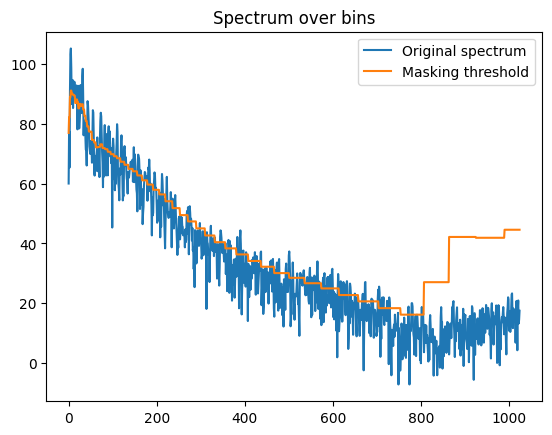

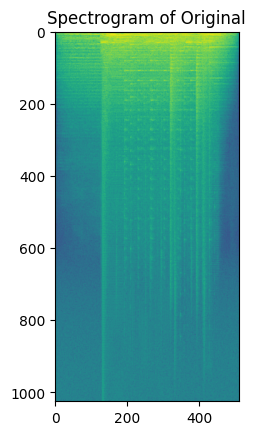

In [25]:
#Test function:
#%cd /content/Python-Audio-Coder
import scipy.signal
import os
#currentpath=os.getcwd()
currentpath=sys.path[0]
print(currentpath)
sys.path.append(currentpath+'/Python-Audio-Coder')
sys.path.append(currentpath+'/Python-Audio-Coder/PythonPsychoacoustics')

print(sys.path)

import psyacloss #from Python file


nfft=2048  #number of fft subbands
N=nfft//2

print("snd.shape=", snd.shape)
f,t,ys=scipy.signal.stft(snd[:,0],fs=2*np.pi,nperseg=2*N)
#scaling for the application of the
#resulting masking threshold to MDCT subbands:
ys *= np.sqrt(2*N/2)/2/0.375

print("fs=", fs)
mT=psyacloss.psyacthresh(ys,fs)

print("mT.shape=",mT.shape)
plt.plot(20*np.log10(np.abs(ys[:,400])+1e-6))
plt.plot(20*np.log10(mT[:,400]+1e-6))
plt.legend(('Original spectrum','Masking threshold'))
plt.title("Spectrum over bins")

plt.figure()
plt.imshow(20*np.log10(np.abs(ys)+1e-6))
plt.title("Spectrogram of Original")


## The psycho-acoustic loss function:
This loss function normalizes the spectral magnitude differences to the masking threshold of the original. That means:
- Its values are non-negative.
- Value 0 means there are no differences.
- Value 1 means the differences are on average around the masking threshold, and should hence be hardly audible, depending on the distribution of the differences.
- The more the values are above 1, the more audible should be the differences.

In [26]:
ploss=psyacloss.percloss(snd, snd_quant, fs) #psycho-acoustic loss from our Python module
print("ploss quantized=", ploss)
#plt.figure()
#plt.plot(20*np.log10(ploss[:,0,400]+1e-6))

ploss quantized= 7809.090890684189


Perceptual loss between original an quantized signal: 7809

In [27]:
#print("snd_aac.shape=", snd_aac.shape)
#print("snd.shape=", snd.shape)
minlen=min(snd.shape[0],snd_aac.shape[0])
print("minlength=",minlength)
ploss_aac=psyacloss.percloss(snd[:minlen,:], snd_aac[delay:minlen+delay,:], fs)
print("ploss aac encoded/decoded=",ploss_aac)

minlength= 519948
ploss aac encoded/decoded= 0.5956013401092173


Perceptual loss between original and AAC encdec signal: 1.6

Observe:
- The loss value for the uniformly quantized version if about **4911 times higher** than for the AAC quantized version.
- As it should, to reflect the hearing properties of the human ear!

## The psycho-acoustic loss function with Pytorch

To use the psycho-acoustic loss function with machine learning training in Pytorch, the psycho-acoustic loss function needs autograd functionality of Pytorch. Hence it needs to be written using Pytorch functions and data types. This can be seen in the following.

In [28]:
import torch
import psyacloss_torch
ploss=psyacloss_torch.percloss(torch.from_numpy(snd[:, 0]).float(), torch.from_numpy(snd_quant[:, 0]).float(), fs)
print("ploss quantized=", ploss)

ploss quantized= tensor(11199.7197)


In [29]:
minlen=min(snd.shape[0],snd_aac.shape[0])
print("minlength=",minlength)
ploss_aac=psyacloss_torch.percloss(torch.from_numpy(snd[:minlen,0]).float(), torch.from_numpy(snd_aac[delay:minlen+delay,0]).float(), fs)
print("ploss aac encoded/decoded=",ploss_aac)

minlength= 519948
ploss aac encoded/decoded= tensor(0.6879)


Observe:
- The loss value for the uniformly quantized version if about **8068 times higher** than for the AAC quantized version.

- This works as well, except for a somewhat different factor. For training this does not matter because only the location of the minimum is important.
- Also observe that the channels and batch dimensions are not implemented yet.

## To do:

- Investigation of losses for audible difference: Which audible distortion sounds better?
- Do the locations of the minima for the different candidates for perceptual loss differ?
- Do the locations of the minima correspond to the best sounding results?

## Conclusions
- The precise psycho-acoustic model leads to a loss minimum where the ear does not perceive a difference between target and produced signal
- Depending on the application, less complex perceptually motivated loss functions might also work
- Minimizing perceptual difference is not guaranteed though for audible differences.
- Full implementation with Pytorch is still needed.